In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from matplotlib import font_manager, rc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings('ignore')
import platform
plt.rc('font', family='NanumBarunGothic') 

from sklearn.ensemble import RandomForestRegressor

import matplotlib.font_manager as fm
#fm._rebuild()
plt.rc('font', family='NanumBarunGothic') 

import lightgbm as lgb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
pd.set_option('display.max_columns', None)

train = pd.read_csv('/gdrive/My Drive/train_new.csv')
test = pd.read_csv('/gdrive/My Drive/test_new.csv')
ratings = pd.read_csv('/gdrive/My Drive/tv_new.csv')
category = pd.read_csv('/gdrive/My Drive/categorized_HJ2.csv') # 카테고리 추가되었습니다.

In [ ]:
def make_cast_time(train): # nan값이 있는 초기 데이터셋을 써야 하기 때문에 가장 먼저 돌려줍니다. 자세한 알고리즘은 창고에서 찾아보세요.

    # 일단 nan값을 노출칼럼에만 남기기 위해서 나머지 nan값 전처리 미리 해버리겠습니다.
    train[' 취급액 '] = train[' 취급액 '].fillna('0')
    train = train[train.상품군 != '무형']

    # nan값 있는 애들을 따로 저장해둡니다.
    train_yes_nan = train[train['노출(분)'].isnull()]
    # nan값 없는 애들을 따로 저장해줍니다. 이놈들로 작업할겁니다.
    train_not_nan = train.dropna()

    # 인덱스 꼬여서 포문 안 돌아가기 때문에 인덱스 리셋하고 나중에 불러와주기 위해서 따로 저장해줍니다.
    train_not_nan_index = train_not_nan.index
    # 리셋 인덱스 해줍니다.
    train_not_nan_reset_index = train_not_nan.reset_index(drop=True)

    # 여기서부터 cast_time, cast_count 포문-----------------------------------------------------
    cast_time = []
    cast_count = []
    time = 0.
    count = 1

    for i in range(len(train_not_nan_reset_index)):
        if i == 0: # 첫번째 행은 이걸로 하십쇼.
            time = train_not_nan_reset_index['노출(분)'][i] # 더하지 않고, 자기 노출을 그대로 가져옵니다.
            count = 1 # count도 1로 초기화 합니다.
            cast_time.append(time) # 그리고 어펜드.
            cast_count.append(count) # 그리고 어펜드.
        elif train_not_nan_reset_index['상품코드'][i] == train_not_nan_reset_index['상품코드'][i-1]: # 자기의 상품코드가 앞행의 상품코드와 같을 때
            time += train_not_nan_reset_index['노출(분)'][i] # 기존 누적된 노출에 자기 노출을 더한다.
            count += 1 # count도 1을 더해줍니다.
            cast_time.append(time) # 그리고 어펜드.
            cast_count.append(count) # 그리고 어펜드.
        else: # 근데 자기 상품코드와 앞행의 상품코드가 다르다면, 새로운 방송이 시작된 거겠죠?
            time = train_not_nan_reset_index['노출(분)'][i] # 더하지 않고, 자기 노출을 그대로 가져옵니다.
            count = 1 # count도 1로 초기화 합니다.
            cast_time.append(time) # 그리고 어펜드.
            cast_count.append(count) # 그리고 어펜드.
    # 포문 끝------------------------------------------------------------  
    # 컬럼으로 박아줍니다.
    train_not_nan_reset_index['cast_time'] = cast_time
    train_not_nan_reset_index['cast_count'] = cast_count
    
    # 여기서부터 cast_time_sum, cast_count_sum 포문-------------------------------------------------
    cast_time_sum = []
    cast_count_sum = []

    for i in range(len(train_not_nan_reset_index)):
        if i == 20587: #마지막은 비교할 다음타자가 없으니 바로 넣기.
            cast_time_sum.append(train_not_nan_reset_index['cast_time'][i])
            cast_count_sum.append(train_not_nan_reset_index['cast_count'][i])
        elif train_not_nan_reset_index['상품코드'][i] == train_not_nan_reset_index['상품코드'][i+1]: # 자기와 다음타자의 상품코드가 같으면
            cast_time_sum.append(np.nan)
            cast_count_sum.append(np.nan)
        else: # 자기와 다음타자의 상품코드가 다르면
            cast_time_sum.append(train_not_nan_reset_index['cast_time'][i])
            cast_count_sum.append(train_not_nan_reset_index['cast_count'][i])
            
    # 포문 끝----------------------------------------------------------------------
    # 칼럼으로 박아줍니다.
    train_not_nan_reset_index['cast_time_sum'] = cast_time_sum
    train_not_nan_reset_index['cast_count_sum'] = cast_count_sum
    # 백필로 nan값 채워줍니다.
    train_not_nan_reset_index.fillna(method='bfill', inplace=True)
    

    # 원래 인덱스 다시 넣어줍니다.
    train_not_nan_reset_index.index = train_not_nan_index
    # 컨캣으로 밑으로 붙여주고,
    train_concat = pd.concat([train_not_nan_reset_index, train_yes_nan], axis=0)
    # 소트 인덱스 먼저 하고,
    train_concat_sort_index = train_concat.sort_index()
    # ffill 로 채워줍니다. 끝. 이거 너무 힘들었다 진짜 레알.
    train = train_concat_sort_index.fillna(method='ffill')
    
    # 누적 방송 시간 비율 칼럼을 만들어줍니다.
    train['cast_time_ratio'] = train.cast_time / train.cast_time_sum
    
    # 인덱스 리셋해줍니다.
    train = train.reset_index(drop=True)
    
    # 다이어트
    train['cast_count'] = train.cast_count.astype(np.int16)
    
    return train

In [ ]:
train = make_cast_time(train)

In [ ]:
# 기본 전처리 함수
def preprocessing_1(df):
    
    # 취급액과 판매단가 수치형 변수로 바꾸기.
    df[' 취급액 '] = df[' 취급액 '].apply(lambda x: x.replace(',', ''))
    df['판매단가'] = df['판매단가'].apply(lambda x: x.replace(',', ''))
    df[' 취급액 '] = df[' 취급액 '].astype(np.int32)
    df['판매단가'] = df['판매단가'].astype(np.int32)
    
    # 칼럼명 너무 어려우니까 쪼금만 바꿔줍니다.
    df = df.rename(columns = {' 취급액 ':'취급액'})
    
    return df

In [ ]:
# 기본 전처리 함수(테스트 용, 둘이 서로 다름)
def preprocessing_2(df):
      
    # 판매단가 수치형 변수로 바꾸기.
    df['판매단가'] = df['판매단가'].apply(lambda x: x.replace(',', ''))
    df['판매단가'] = df['판매단가'].astype(np.int32)
    
    return df

In [ ]:
train = preprocessing_1(train)

In [ ]:
# 상품명 전처리 함수
def preprocessing_3(train):
    # 1. 일시불/무이자/없음
    train.loc[train['상품명'].str.contains('일시불') == True, "상품명_plan"] = '1'
    train.loc[train['상품명'].str.contains('일\)') == True, "상품명_plan"] = '1'
    train.loc[train['상품명'].str.contains('무이자') == True, "상품명_plan"] = '2'
    train.loc[train['상품명'].str.contains('무\)') == True, "상품명_plan"] = '2'
    train['상품명_plan'] = train['상품명_plan'].fillna('0')

    # 2. 추가구성/단품구성
    train.loc[train['상품명'].str.contains('\+') == True, "상품명_add"] = '1'
    train['상품명_add'] = train['상품명_add'].fillna('0')

    # 3. 기타/삼성/LG
    train.loc[train['상품명'].str.contains('삼성') == True, "상품명_maker"] = '1'
    train.loc[train['상품명'].str.contains('LG') == True, "상품명_maker"] = '2'
    train['상품명_maker'] = train['상품명_maker'].fillna('0')

    # 4. 세트구성/단품구성
    train.loc[train['상품명'].str.contains('세트') == True, "상품명_set"] = '1'
    train['상품명_set'] = train['상품명_set'].fillna('0')

    # 5. 여성/남성/없음
    train.loc[train['상품명'].str.contains('여성') == True, "상품명_sex"] = '1'
    #train.loc[train['상품명'].str.contains('브라') == True, "상품명_sex"] = '1'
    #train.loc[train['상품명'].str.contains('란쥬') == True, "상품명_sex"] = '1'
    #train.loc[train['상품명'].str.contains('블라우스') == True, "상품명_sex"] = '1'
    #train.loc[train['상품명'].str.contains('밍크') == True, "상품명_sex"] = '1'
    train.loc[train['상품명'].str.contains('남성') == True, "상품명_sex"] = '2'
    #train.loc[train['상품명'].str.contains('드로즈') == True, "상품명_sex"] = '2'
    #train.loc[train['상품명'].str.contains('트렁크') == True, "상품명_sex"] = '2'
    train['상품명_sex'] = train['상품명_sex'].fillna('0')

    # category로 형변환해서 다이어트 시켜줍니다.
    train['상품명_plan'] = train['상품명_plan'].astype('category')
    train['상품명_add'] = train['상품명_add'].astype('category')
    train['상품명_maker'] = train['상품명_maker'].astype('category')
    train['상품명_set'] = train['상품명_set'].astype('category')
    train['상품명_sex'] = train['상품명_sex'].astype('category')
    
    return train

In [ ]:
train = preprocessing_3(train)
train.sample()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,cast_time,cast_count,cast_time_sum,cast_count_sum,cast_time_ratio,상품명_plan,상품명_add,상품명_maker,상품명_set,상품명_sex
12396,2019-05-01 12:40,20.0,100489,201473,삭루츠 크로스바디백(TQ12),잡화,44000,16958000,60.0,3,60.0,3.0,1.0,0,0,0,0,0


In [ ]:
def make_fake_weight(train):
    fake_weight = []
    weight = 1

    for i in range(len(train)):
        if i == 0: # 첫번째 행은 이걸로 하십쇼.
            weight = 1 # count도 1로 초기화 합니다.
            fake_weight.append(weight) # 그리고 어펜드.
            
        elif train['마더코드'][i] == train['마더코드'][i-1]: # 자기의 마더코드가 앞행의 것과 같을 때
            if train['판매단가'][i] < train['판매단가'][i-1]: # 자기의 단가가 앞행의 것보다 작으면(같으면 안됨)
                weight +=1 # 가중치 1을 더하고,
                fake_weight.append(weight) # 그리고 어펜드
            else: # 자기의 단가가 앞행의 것과 같거나 더 크면(더 클 수는 없음.)
                weight = 1 # 가중치 1로 초기화
                fake_weight.append(weight)
                
        else: # 근데 자기 마더코드와 앞행의 마더코드가 다르다면, 새로운 방송이 시작된 거겠죠?
            weight = 1 # 가중치 1로 초기화
            fake_weight.append(weight)
            
    train['fake_weight'] = fake_weight
    train['fake_weight'] = train.fake_weight.apply(lambda x: -(x*x))
    
    return train

In [ ]:
train = make_fake_weight(train)

In [ ]:
def make_fake_weight2(train):
    fake_weight = []
    weight = 0

    for i in range(len(train)):
        if i == 0: # 첫번째 행은 이걸로 하십쇼.
            weight = 0 # count도 1로 초기화 합니다.
            fake_weight.append(weight) # 그리고 어펜드.
            
        elif train['마더코드'][i] == train['마더코드'][i-1]: # 자기의 마더코드가 앞행의 것과 같을 때
            if train['판매단가'][i] == train['판매단가'][i-1]: # 자기의 단가가 앞행의 것과 같을 때
                if train['방송일시'][i] == train['방송일시'][i-1]:
                    if train['상품코드'][i] != train['상품코드'][i-1]: # 상품코드는 일치하지 않으면 조건 성립
                        weight -=1 # 가중치 1을 빼고,
                        fake_weight.append(weight) # 그리고 어펜드
                    else: # 상품코드까지 같으면 동일 상품.
                        weight = 0
                        fake_weight.append(weight)
                else: #방송일시가 다르면 새로운 방송 시작
                    weight = 0 # 가중치 0로 초기화
                    fake_weight.append(weight)
            else: # 판매단가가 다르면 다른 상품
                weight = 0 # 가중치 0로 초기화
                fake_weight.append(weight)
        else: # 근데 자기 마더코드와 앞행의 마더코드가 다르다면, 새로운 방송이 시작된 거겠죠?
            weight = 0 # 가중치 1로 초기화
            fake_weight.append(weight)
            
    train['fake_weight2'] = fake_weight
    
    return train

In [ ]:
# 더 정확한 변수 생성을 위해 기계가 걸러내지 못하는 조건을 쳐내줍니다.
train_fake = train[train.상품명_plan == '0'] # 할부플랜이 다른 애들 쳐내기
train_fake = train_fake[train_fake.상품명_sex == '0'] # 성별이 다른 애들 쳐내기.
# 포문 돌리기 위해 인덱스 리셋 해줍니다.
train_fake.reset_index(drop=True, inplace=True)

In [ ]:
# 쳐낸 데이터프레임을 함수로 엮어서 만들어줍니다.
train_fake = make_fake_weight2(train_fake)

In [ ]:
# 기존 데이터에 합쳐줍니다.
train = pd.merge(train, train_fake[['방송일시','마더코드','상품코드','상품명','판매단가', 'fake_weight2']],
                 on=['방송일시','마더코드','상품코드','상품명','판매단가'], how='left')

In [ ]:
# 빈 값은 전부 0으로 채워줍니다.
train['fake_weight2'] = train.fake_weight2.fillna(0)

In [ ]:
# 난 값 먼저 채워 줍니다.
category['cat3'] = category.apply(lambda x: x['cat2'] if x['cat3'] != x['cat3'] else x['cat3'], axis=1)

In [ ]:
def preprocessing_to_merge(df):
    # merge를 위해 datetime으로 바꿔줍니다..
    df['방송일시'] = pd.to_datetime(df['방송일시'], errors='coerce')
    df['방송일시'] = df['방송일시'].astype(str)
    
    # key 칼럼을 만들어줍니다. 방송일시만으로는 안되니, 방송일시+상품명을 해줍니다.
    df['key'] = df['방송일시'] + df['상품명']
    
    return df

In [ ]:
def preprocessing_merging(df1, df2):
    # df1이 왼쪽, df2가 오른쪽입니다.
    df3 = pd.merge(df1, df2[['key','ratings_mean','cat1','cat2','cat3']], how='left', on=['key'])
    df3 = df3.drop('key', axis=1) # key 칼럼은 드랍.
    
    return df3

In [ ]:
train = preprocessing_to_merge(train)
category = preprocessing_to_merge(category)
train = preprocessing_merging(train, category)

In [ ]:
# 방송일시 쪼개기 전처리 함수
def preprocessing_4(train):
    # datetime으로 바꿔줍니다.
    train['방송일시'] = pd.to_datetime(train['방송일시'], errors='coerce')
   
    # 월일이 다음날로 넘어가는 것을 막기 위해서 3시간씩 앞으로 땡겨줍니다. 마지막에 다시 더해줘야 합니다.
    delta = datetime.timedelta(hours=3)
    train['방송일시'] = train.방송일시.apply(lambda x: x - delta)

    # dayofweek는 날짜에서 요일(월~일)을 가져오는 기능입니다.
    # 값은 0(월), 1(화), 2(수), 3(목), 4(금), 5(토), 6(일) 을 나타냅니다.
    train["방송일시_dow"] = train["방송일시"].dt.dayofweek

    # 요일 외에 다른 정보를 가져오기 위해서 다시 string으로 바꿔줍니다.
    train['방송일시'] = train.방송일시.astype(str)

    # MMDDhhmm 정보를 가져옵니다.
    train['방송일시_MM'] = train['방송일시'].apply(lambda x: x[5:7])
    train['방송일시_DD'] = train['방송일시'].apply(lambda x: x[8:10])
    train['방송일시_hh'] = train['방송일시'].apply(lambda x: x[11:13])
    train['방송일시_mm'] = train['방송일시'].apply(lambda x: x[14:16])

    # schedule 관련 칼럼을 더 만들어보겠습니다. # MMDD # DDHH # HHMM # weekday/weekends
    train['방송일시_MMDD'] = train['방송일시_MM'] + train['방송일시_DD']
    train['방송일시_DDhh'] = train['방송일시_DD'] + train['방송일시_hh']
    train['방송일시_hhmm'] = train['방송일시_hh'] + train['방송일시_mm']
    train['방송일시_MMDDhh'] = train['방송일시_MM'] + train['방송일시_DD'] + train['방송일시_hh']

    # mmmm_1 은 1일 사이클로 분단위로 환산한 것
    # mmmm_2 는 1달 사이클로 분단위로 환산한 것
    # mmmm_3 는 1년 사이클로 분단위로 환산한 것
    train['방송일시_mmmm_1'] = train['방송일시_hh'].astype(int) * train['방송일시_mm'].astype(int) * 60
    train['방송일시_mmmm_2'] = train['방송일시_DD'].astype(int) * train['방송일시_hh'].astype(int) * train['방송일시_mm'].astype(int) * 60
    train['방송일시_mmmm_3'] = train['방송일시_MM'].astype(int) * train['방송일시_DD'].astype(int) * train['방송일시_hh'].astype(int) * train['방송일시_mm'].astype(int) * 60

    # weekday = 1 / weekends = 0
    train.loc[train.방송일시_dow == 5, '방송일시_dow2'] = '0'
    train.loc[train.방송일시_dow == 6, '방송일시_dow2'] = '0'
    train['방송일시_dow2'] = train.방송일시_dow2.fillna('1')
    
    #다이어트
    train['방송일시_dow'] = train.방송일시_dow.astype(np.int16)
    train['방송일시_MM'] = train.방송일시_MM.astype('category')
    train['방송일시_DD'] = train.방송일시_DD.astype('category')
    train['방송일시_hh'] = train.방송일시_hh.astype('category')
    train['방송일시_mm'] = train.방송일시_mm.astype('category')
    train['방송일시_MMDD'] = train.방송일시_MMDD.astype('category')
    train['방송일시_DDhh'] = train.방송일시_DDhh.astype('category')
    train['방송일시_hhmm'] = train.방송일시_hhmm.astype('category')
    train['방송일시_dow2'] = train.방송일시_dow2.astype('category')
    
    return train

In [ ]:
import datetime
train = preprocessing_4(train)
train.sample()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,cast_time,cast_count,cast_time_sum,cast_count_sum,cast_time_ratio,상품명_plan,상품명_add,상품명_maker,상품명_set,상품명_sex,fake_weight,fake_weight2,ratings_mean,cat1,cat2,cat3,방송일시_dow,방송일시_MM,방송일시_DD,방송일시_hh,방송일시_mm,방송일시_MMDD,방송일시_DDhh,방송일시_hhmm,방송일시_MMDDhh,방송일시_mmmm_1,방송일시_mmmm_2,방송일시_mmmm_3,방송일시_dow2
13983,2019-05-13 20:20:00,20.0,100089,200241,헤비추얼 남성 썸머 쿨라이프 데님 3종,의류,59000,18977000,40.0,2,60.0,3.0,0.666667,0,0,0,0,2,-1,0.0,0.004447,패션의류,남성의류,청바지,0,05,13,20,20,0513,1320,2020,051320,24000,312000,1560000,1


In [ ]:
def pre_nlp(train):
    # 제품명에서 불필요한 요소 전처리
    new_product_name = []

    re_stop = re.compile("""\([가-힣]{1,5}\+[가-힣]{1,5}\)|\(?무이자\)?\s?|\(?일시불\)?\s?|\(?초특가\)?\s?|\(?무\)\s?|\(?유\)\s?|\(?일\)\s?|무료체험|
    |포함|국내[가-힣]+\s|무료설치|\s?신제품\s?|\s?패키지\s?|[0-9]+종|풀코디|set|SET|풀세트|[0-9]+세트|더블팩|싱글팩|[0-9]{1,2}\+[0-9]{1,2}|[0-9]{1,2}인용|[0-9]{1,2}박스|[0-9\.]{1,4}미터|[0-9\.]{1,4}kg|[0-9\.]{1,4}[kKgG]|[0-9]{1,3}[벌롤종단구대P개통병포미봉팩장gL매]|
    |\s[0-9\.]{1,4}[Mm]|\(.{1,10}\)$|^\(.?\)|^[0-9]{2,4}\s|\s+[0-9]{2,4}\s|[0-9]{2,4}년\s|[0-9]{2,4}년형\s|시즌[0-9]|[0-9]{1,3}\%|\(.{1,20}\)$|기본형|고급형|오리지널|[대중소大中小]형|.{1,10}by|,|\s?총[0-9\s]|^[가-힣a-zA-Z]{3,3}의|
    |S\/S|F\/W|f\/w|s\/s|[가-힣]+형\s|[슈퍼]{0,2}싱글|\s[SQK퀸킹]{1,2}\s|[SQK퀸킹]{1,2}$|[가-힣]{0,2}사이즈""")

    remnants = re.compile('[",g\+lL-]\s|ml|_|\sx|[\[\]\］!"#$%&\'()*+,./:;<=>?@\^_`{|}~-]|\s종$|\s[0-9]+\s|\s{2,}')

    for i in train.상품명:
        tmp = re_stop.sub(' ',i)
        tmp = tmp.strip()
        tmp = remnants.sub(' ',tmp)
        new_product_name.append(tmp.strip())
    
    train['new_상품명'] = new_product_name
    
    # 상품명에서 브랜드 추출
    train['상품명_brand'] = train['new_상품명'].apply(lambda x: x[:2])
    
    return train

In [ ]:
import re
train = pre_nlp(train)

In [ ]:
# 크롤링 DF 가져와서 합쳐줍니다.

naver = pd.read_csv('/gdrive/My Drive/naver.csv')
train = pd.merge(train, naver, on='상품명', how='left')

# 전처리 해줍니다.
train['review_counts'] = train['review_counts'].apply(lambda x: x.replace(',',''))
train['internet_price'] = train['internet_price'].apply(lambda x: x.replace(',',''))
train['internet_price'] = train['internet_price'].apply(lambda x: x.replace('원',''))
train['review_counts'] = train['review_counts'].astype(int)
train['internet_price'] = train['internet_price'].astype(int)

In [ ]:
# 오차를 컬럼으로 만들어줍니다.
train['price_minus'] = train['판매단가'] - train['internet_price']
# 네이버에 서칭이 되는지 여부를 알려줍니다.
train['search_naver'] = train['internet_price'] + train['review_counts']
train['search_naver'] = train['search_naver'].apply(lambda x: 0 if x == 0 else 1)

In [ ]:
# 기상청 통계 파일 읽기
weather = pd.read_csv('/gdrive/My Drive/OBS_ASOS_TIM_20200902192155.csv', encoding='latin1')
columns = ['location_id','location','date','temperature']
weather.columns = columns

# datetime으로 바꿔줍니다.
weather['date'] = pd.to_datetime(weather['date'], errors='coerce')

# 월일이 다음날로 넘어가는 것을 막기 위해서 3시간씩 앞으로 땡겨줍니다. 마지막에 다시 더해줘야 합니다.
delta = datetime.timedelta(hours=3)
weather['date'] = weather.date.apply(lambda x: x - delta)

# 요일 외에 다른 정보를 가져오기 위해서 다시 string으로 바꿔줍니다.
weather['date'] = weather.date.astype(str)

In [ ]:
# key column 만들어주기.
weather['방송일시_MMDDhh'] = weather['date'].apply(lambda x: x[5:7]) + weather['date'].apply(lambda x: x[8:10]) + weather['date'].apply(lambda x: x[11:13])

# 필요없는 칼럼은 미리 버려줍니다.
weather.drop(['location_id', 'location', 'date'], axis=1, inplace=True)

# 합쳐줍니다.
train = pd.merge(train, weather, on='방송일시_MMDDhh', how='left')

In [ ]:
# MAPE nan 값 안 뜨도록 취급액 0원인 애들 죽여줍니다.

train = train[train.취급액 != 0]
train.shape

(35379, 44)

In [ ]:
train_, test_ = train_test_split(train, test_size=0.2, random_state=529)

#train_ = train[train.방송일시_MM != '07']
#test_ = train[train.방송일시_MM == '07']
print(train_.shape)
print(test_.shape)

(28303, 44)
(7076, 44)


In [ ]:
# train 셋의 아웃라이어를 제거해봅니다...

train_ = train_[train_.취급액 < 100000000]
train_.shape

(28150, 44)

In [ ]:
# 라벨인코딩 숫자가 많아지니 함수로 만들어버립니다.

def label_encoding(train_, test_, columns, number):
  length = range(number)
  for c, i in zip(columns, length):
    # 라벨인코더 피팅
    globals()['encoder_{}:'.format(i)] = LabelEncoder()
    globals()['encoder_{}:'.format(i)].fit(train_[c].values)
        
    # 트레인셋에 트랜스폼
    train_['encoding_{}:'.format(c)] = globals()['encoder_{}:'.format(i)].transform(train_[c])
        
    # 테스트셋에 트랜스폼
    for label in np.unique(test_[c]):
      if label not in globals()['encoder_{}:'.format(i)].classes_: # unseen label 데이터인 경우( )
        globals()['encoder_{}:'.format(i)].classes_ = np.append(globals()['encoder_{}:'.format(i)].classes_, label) # 미처리 시 ValueError발생
    test_['encoding_{}:'.format(c)] = globals()['encoder_{}:'.format(i)].transform(test_[c])

In [ ]:
# 인코딩할 컬럼을 리스트로 넣어줍니다.
columns = ['상품명', '상품군', '상품명_brand', 'cat1', 'cat2', 'cat3', 'new_상품명']
number = len(columns)

# 함수로 바로 처리.
label_encoding(train_, test_, columns, number)
train_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28150 entries, 19091 to 6313
Data columns (total 51 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   방송일시                 28150 non-null  object  
 1   노출(분)                28150 non-null  float64 
 2   마더코드                 28150 non-null  int64   
 3   상품코드                 28150 non-null  int64   
 4   상품명                  28150 non-null  object  
 5   상품군                  28150 non-null  object  
 6   판매단가                 28150 non-null  int32   
 7   취급액                  28150 non-null  int32   
 8   cast_time            28150 non-null  float64 
 9   cast_count           28150 non-null  int16   
 10  cast_time_sum        28150 non-null  float64 
 11  cast_count_sum       28150 non-null  float64 
 12  cast_time_ratio      28150 non-null  float64 
 13  상품명_plan             28150 non-null  category
 14  상품명_add              28150 non-null  category
 15  상품명_maker       

In [ ]:
# rating_mean 은 일단 제외하고 학습합니다.
# 변수 순서가 바뀌면 점수가 바뀝니다.

X_train = train_[['노출(분)', '마더코드', '상품코드', '판매단가','cast_time', 'cast_count', 'cast_time_sum', 'cast_count_sum', 'cast_time_ratio','fake_weight',
       '상품명_plan', '상품명_add', '상품명_maker',
       '상품명_set', '상품명_sex', '방송일시_dow', '방송일시_MM', '방송일시_DD', '방송일시_hh',
       '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm', '방송일시_mmmm_1',
       '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2', 'review_counts', 'price_minus', 'search_naver', 'temperature',
       'encoding_상품명:', 'encoding_상품군:', 'encoding_상품명_brand:',
       'encoding_cat1:', 'encoding_cat2:', 'encoding_cat3:','fake_weight2',
       'encoding_new_상품명:']].values 
y_train = train_['취급액'].values
X_test = test_[['노출(분)', '마더코드', '상품코드', '판매단가','cast_time', 'cast_count', 'cast_time_sum', 'cast_count_sum','cast_time_ratio','fake_weight',
       '상품명_plan', '상품명_add', '상품명_maker',
       '상품명_set', '상품명_sex', '방송일시_dow', '방송일시_MM', '방송일시_DD', '방송일시_hh',
       '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm', '방송일시_mmmm_1',
       '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2', 'review_counts', 'price_minus', 'search_naver','temperature',
       'encoding_상품명:', 'encoding_상품군:', 'encoding_상품명_brand:',
       'encoding_cat1:', 'encoding_cat2:', 'encoding_cat3:','fake_weight2',
      'encoding_new_상품명:']].values 
y_test = test_['취급액'].values

In [ ]:
y_train_log = np.log(y_train)

# np.exp(1)**np.log(10)

In [ ]:
# 로그 표준화한 값을 학습(예측용)
rf = RandomForestRegressor(n_jobs=3, random_state=592)
rf.fit(X_train, y_train_log)
pred_log = rf.predict(X_test)

In [ ]:
def mape(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

pred_log_T = np.exp(1)**pred_log

In [ ]:
mape(y_test, pred_log_T)

33.61818596472667

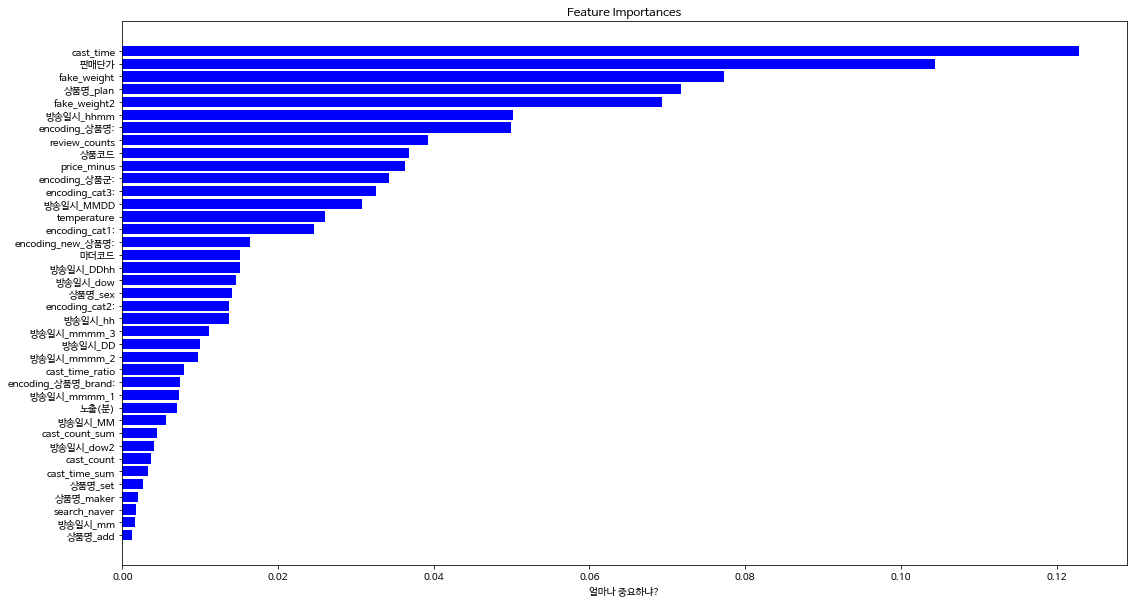

In [ ]:
features = ['노출(분)', '마더코드', '상품코드', '판매단가','cast_time', 'cast_count', 'cast_time_sum', 'cast_count_sum','cast_time_ratio', 'fake_weight',
       '상품명_plan', '상품명_add', '상품명_maker',
       '상품명_set', '상품명_sex', '방송일시_dow', '방송일시_MM', '방송일시_DD', '방송일시_hh',
       '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm', '방송일시_mmmm_1',
       '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2','review_counts','price_minus', 'search_naver', 'temperature',
       'encoding_상품명:', 'encoding_상품군:', 'encoding_상품명_brand:',
       'encoding_cat1:', 'encoding_cat2:', 'encoding_cat3:','fake_weight2',
       'encoding_new_상품명:']
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(18,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('얼마나 중요하냐?')
plt.show()

In [ ]:
train.shape

(35379, 44)

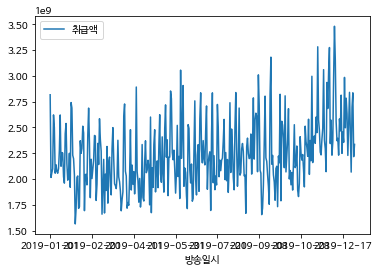

In [ ]:
tmp = train[['방송일시','취급액']]
tmp['방송일시'] = tmp['방송일시'].apply(lambda x: x[:-9])
tmp.groupby('방송일시').sum()[['취급액']].plot()

In [ ]:
kospi = pd.read_csv('/gdrive/My Drive/코스피지수 내역.csv')
kospi.head()

,날짜,종가,오픈,고가,저가,거래량,변동 %
0,2019년 12월 30일,"2,197.67","2,202.62","2,208.04","2,195.65",416.40M,-0.30%
1,2019년 12월 27일,"2,204.21","2,183.70","2,215.55","2,177.40",490.17M,0.29%
2,2019년 12월 26일,"2,197.93","2,192.22","2,198.01","2,183.90",571.31M,0.36%
3,2019년 12월 24일,"2,190.08","2,206.23","2,206.23","2,187.58",569.97M,-0.62%
4,2019년 12월 23일,"2,203.71","2,208.22","2,209.20","2,196.43",502.03M,-0.02%


In [ ]:
kospi = kospi[['날짜','변동 %']]

In [ ]:
kospi['변동 %'] = kospi['변동 %'].apply(lambda x: x[:-1])
kospi['변동 %'] = kospi['변동 %'].astype(float)
kospi.head()

,날짜,변동 %
0,2019년 12월 30일,-0.30
1,2019년 12월 27일,0.29
2,2019년 12월 26일,0.36
3,2019년 12월 24일,-0.62
4,2019년 12월 23일,-0.02


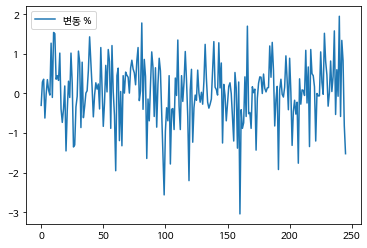

In [ ]:
kospi.sort_values(by='날짜', ascending = True).plot()

In [ ]:
kospi['날짜'][200][6:12]

'03월 12'

In [ ]:
kospi['날짜'] = kospi['날짜'].apply(lambda x: x[6:12])
kospi['날짜'] = kospi['날짜'].apply(lambda x: x.replace('월 ',''))
kospi.head()

,날짜,변동 %
0,1230,-0.30
1,1227,0.29
2,1226,0.36
3,1224,-0.62
4,1223,-0.02


In [ ]:
train = pd.merge(train, kospi, left_on = '방송일시_MMDD',right_on = '날짜',how='left')
del train['날짜']


In [ ]:
train['변동 %'] =train['변동 %'].fillna(0)

In [ ]:
train.shape

(35379, 45)

In [ ]:
train_, test_ = train_test_split(train, test_size=0.2, random_state=529)

#train_ = train[train.방송일시_MM != '07']
#test_ = train[train.방송일시_MM == '07']
print(train_.shape)
print(test_.shape)

(28303, 45)
(7076, 45)


In [ ]:
# train 셋의 아웃라이어를 제거해봅니다...

train_ = train_[train_.취급액 < 100000000]
train_.shape

(28150, 45)

In [ ]:
# 라벨인코딩 숫자가 많아지니 함수로 만들어버립니다.

def label_encoding(train_, test_, columns, number):
  length = range(number)
  for c, i in zip(columns, length):
    # 라벨인코더 피팅
    globals()['encoder_{}:'.format(i)] = LabelEncoder()
    globals()['encoder_{}:'.format(i)].fit(train_[c].values)
        
    # 트레인셋에 트랜스폼
    train_['encoding_{}:'.format(c)] = globals()['encoder_{}:'.format(i)].transform(train_[c])
        
    # 테스트셋에 트랜스폼
    for label in np.unique(test_[c]):
      if label not in globals()['encoder_{}:'.format(i)].classes_: # unseen label 데이터인 경우( )
        globals()['encoder_{}:'.format(i)].classes_ = np.append(globals()['encoder_{}:'.format(i)].classes_, label) # 미처리 시 ValueError발생
    test_['encoding_{}:'.format(c)] = globals()['encoder_{}:'.format(i)].transform(test_[c])

In [ ]:
# 인코딩할 컬럼을 리스트로 넣어줍니다.
columns = ['상품명', '상품군', '상품명_brand', 'cat1', 'cat2', 'cat3', 'new_상품명']
number = len(columns)

# 함수로 바로 처리.
label_encoding(train_, test_, columns, number)
train_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28150 entries, 17937 to 6025
Data columns (total 52 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   방송일시                 28150 non-null  object  
 1   노출(분)                28150 non-null  float64 
 2   마더코드                 28150 non-null  int64   
 3   상품코드                 28150 non-null  int64   
 4   상품명                  28150 non-null  object  
 5   상품군                  28150 non-null  object  
 6   판매단가                 28150 non-null  int32   
 7   취급액                  28150 non-null  int32   
 8   cast_time            28150 non-null  float64 
 9   cast_count           28150 non-null  int16   
 10  cast_time_sum        28150 non-null  float64 
 11  cast_count_sum       28150 non-null  float64 
 12  cast_time_ratio      28150 non-null  float64 
 13  상품명_plan             28150 non-null  category
 14  상품명_add              28150 non-null  category
 15  상품명_maker       

In [ ]:
# rating_mean 은 일단 제외하고 학습합니다.
# 변수 순서가 바뀌면 점수가 바뀝니다.

X_train = train_[['노출(분)', '마더코드', '상품코드', '판매단가','cast_time', 'cast_count', 'cast_time_sum', 'cast_count_sum', 'cast_time_ratio','fake_weight',
       '상품명_plan', '상품명_add', '상품명_maker',
       '상품명_set', '상품명_sex', '방송일시_dow', '방송일시_MM', '방송일시_DD', '방송일시_hh',
       '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm', '방송일시_mmmm_1',
       '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2', 'review_counts', 'price_minus', 'search_naver', 'temperature',
       'encoding_상품명:', 'encoding_상품군:', 'encoding_상품명_brand:',
       'encoding_cat1:', 'encoding_cat2:', 'encoding_cat3:','fake_weight2',
       'encoding_new_상품명:','변동 %']].values 
y_train = train_['취급액'].values
X_test = test_[['노출(분)', '마더코드', '상품코드', '판매단가','cast_time', 'cast_count', 'cast_time_sum', 'cast_count_sum','cast_time_ratio','fake_weight',
       '상품명_plan', '상품명_add', '상품명_maker',
       '상품명_set', '상품명_sex', '방송일시_dow', '방송일시_MM', '방송일시_DD', '방송일시_hh',
       '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm', '방송일시_mmmm_1',
       '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2', 'review_counts', 'price_minus', 'search_naver','temperature',
       'encoding_상품명:', 'encoding_상품군:', 'encoding_상품명_brand:',
       'encoding_cat1:', 'encoding_cat2:', 'encoding_cat3:','fake_weight2',
      'encoding_new_상품명:','변동 %']].values 
y_test = test_['취급액'].values

In [ ]:
y_train_log = np.log(y_train)

# np.exp(1)**np.log(10)

In [ ]:
# 로그 표준화한 값을 학습(예측용)
rf = RandomForestRegressor(n_jobs=3, random_state=592)
rf.fit(X_train, y_train_log)
pred_log = rf.predict(X_test)

In [ ]:
def mape(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

pred_log_T = np.exp(1)**pred_log

In [ ]:
mape(y_test, pred_log_T)

33.52511384237675

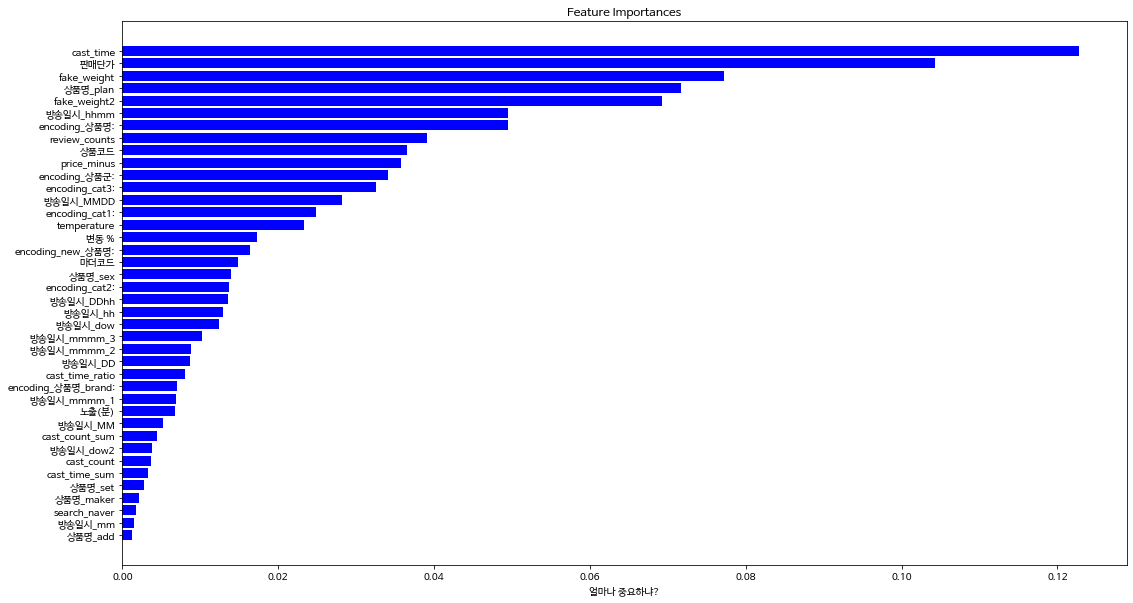

In [ ]:
features = ['노출(분)', '마더코드', '상품코드', '판매단가','cast_time', 'cast_count', 'cast_time_sum', 'cast_count_sum','cast_time_ratio', 'fake_weight',
       '상품명_plan', '상품명_add', '상품명_maker',
       '상품명_set', '상품명_sex', '방송일시_dow', '방송일시_MM', '방송일시_DD', '방송일시_hh',
       '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm', '방송일시_mmmm_1',
       '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2','review_counts','price_minus', 'search_naver', 'temperature',
       'encoding_상품명:', 'encoding_상품군:', 'encoding_상품명_brand:',
       'encoding_cat1:', 'encoding_cat2:', 'encoding_cat3:','fake_weight2',
       'encoding_new_상품명:','변동 %']
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(18,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('얼마나 중요하냐?')
plt.show()

In [ ]:
# 같은 시간에 방송한거 same 이름으로 묶어줌
train['same'] = 1
for i in range(1,len(train)):
  if train['cast_count'][i] == train['cast_count'][i-1]:
    train['same'][i] = train['same'][i-1]
  else:
    train['same'][i] = train['same'][i-1] + 1

In [ ]:
# 같은 시간에 여러 품목 방송했는지 알기 위해 cast_count_com 변수 새로 생성
train = pd.merge(train, train.groupby('same').sum().reset_index()[['same','cast_count']], on ='same', how='left')
train.rename({'cast_count_x':'cast_count', 'cast_count_y':'cast_count_com'}, axis=1, inplace= True)

In [ ]:
# 최종 비교 위해 com 또 생성
train['com'] = train['cast_count'] - train['cast_count_com']

In [ ]:
# 같은 방송 여러 품목에 fw라는 순번을 붙여줌
tmp = train.copy()
tmp = tmp[tmp['com'] != 0]
tmp.reset_index(drop=True, inplace=True)
tmp['fw'] = 1
for i in range(1, len(tmp)):
  if tmp['same'][i] == tmp['same'][i-1]:
    tmp['fw'][i] = tmp['fw'][i-1]+1
  else:
    pass

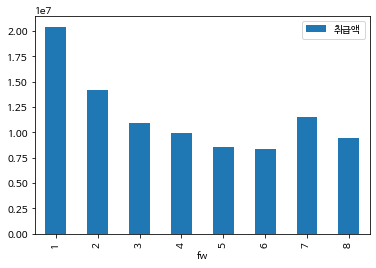

In [ ]:
# 그림으로 순번별 취급액 차이 파악
tmp.drop(['상품군','cat1','cat2','cat3','new_상품명'],axis=1).groupby('fw').mean()[['취급액']].plot(kind='bar')

In [ ]:
tmp.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,cast_time,cast_count,cast_time_sum,cast_count_sum,cast_time_ratio,상품명_plan,상품명_add,상품명_maker,상품명_set,상품명_sex,fake_weight,fake_weight2,ratings_mean,cat1,cat2,cat3,방송일시_dow,방송일시_MM,방송일시_DD,방송일시_hh,방송일시_mm,방송일시_MMDD,방송일시_DDhh,방송일시_hhmm,방송일시_MMDDhh,방송일시_mmmm_1,방송일시_mmmm_2,방송일시_mmmm_3,방송일시_dow2,new_상품명,상품명_brand,review_counts,internet_price,price_minus,search_naver,temperature,변동 %,same,cast_count_com,com,fw
0,2019-01-01 03:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000,20.0,1,60.0,3.0,0.333333,0,0,0,0,2,-1,0.0,0.002255,패션의류,남성의류,니트/스웨터,1,01,01,03,00,0101,0103,0300,010103,0,0,0,1,테이트 남성 셀린니트,테이,1,68510,-28610,1,-7.9,0.0,1,2,-1,1
1,2019-01-01 03:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000,20.0,1,60.0,3.0,0.333333,0,0,0,0,1,-1,0.0,0.002255,패션의류,여성의류,니트/스웨터,1,01,01,03,00,0101,0103,0300,010103,0,0,0,1,테이트 여성 셀린니트,테이,1,39110,790,1,-7.9,0.0,1,2,-1,2
2,2019-01-01 03:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000,40.0,2,60.0,3.0,0.666667,0,0,0,0,2,-1,0.0,0.002210,패션의류,남성의류,니트/스웨터,1,01,01,03,20,0101,0103,0320,010103,3600,3600,3600,1,테이트 남성 셀린니트,테이,1,68510,-28610,1,-7.9,0.0,2,4,-2,1
3,2019-01-01 03:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000,40.0,2,60.0,3.0,0.666667,0,0,0,0,1,-1,0.0,0.002210,패션의류,여성의류,니트/스웨터,1,01,01,03,20,0101,0103,0320,010103,3600,3600,3600,1,테이트 여성 셀린니트,테이,1,39110,790,1,-7.9,0.0,2,4,-2,2
4,2019-01-01 03:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000,60.0,3,60.0,3.0,1.000000,0,0,0,0,2,-1,0.0,0.001997,패션의류,남성의류,니트/스웨터,1,01,01,03,40,0101,0103,0340,010103,7200,7200,7200,1,테이트 남성 셀린니트,테이,1,68510,-28610,1,-7.9,0.0,3,6,-3,1


In [ ]:
# 다시 train 데이터에 fw 붙여주기 fake_weight3으로 이름 붙이기
train = pd.merge(train, tmp[['방송일시','상품명','fw']], on =['방송일시','상품명'], how = 'left')
train.rename({'fw':'fake_weight3'},axis=1,inplace=True)
train.drop(['same','cast_count_com'], axis=1, inplace=True)
#train['fw'] = train['fw'].astype(int)

KeyError: ignored

In [ ]:
train['fake_weight3']=train['fake_weight3'].fillna(0)
train['fake_weight3'] = train['fake_weight3'].astype(int)

In [ ]:
# 한 방송에 여러상품 포함하면 1 아니면 0
train['com'] = train['com'].apply(lambda x: 1 if x==0 else 0)
train['com'].value_counts()

0    22602
1    12777
Name: com, dtype: int64

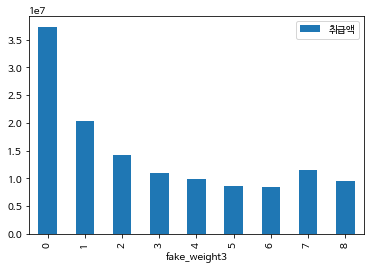

In [ ]:
train.groupby('fake_weight3').mean()[['취급액']].plot(kind='bar')

In [ ]:
train_, test_ = train_test_split(train, test_size=0.2, random_state=529)

#train_ = train[train.방송일시_MM != '07']
#test_ = train[train.방송일시_MM == '07']
print(train_.shape)
print(test_.shape)

(28303, 47)
(7076, 47)


In [ ]:
# train 셋의 아웃라이어를 제거해봅니다...

train_ = train_[train_.취급액 < 100000000]
train_.shape

(28150, 47)

In [ ]:
# 라벨인코딩 숫자가 많아지니 함수로 만들어버립니다.

def label_encoding(train_, test_, columns, number):
  length = range(number)
  for c, i in zip(columns, length):
    # 라벨인코더 피팅
    globals()['encoder_{}:'.format(i)] = LabelEncoder()
    globals()['encoder_{}:'.format(i)].fit(train_[c].values)
        
    # 트레인셋에 트랜스폼
    train_['encoding_{}:'.format(c)] = globals()['encoder_{}:'.format(i)].transform(train_[c])
        
    # 테스트셋에 트랜스폼
    for label in np.unique(test_[c]):
      if label not in globals()['encoder_{}:'.format(i)].classes_: # unseen label 데이터인 경우( )
        globals()['encoder_{}:'.format(i)].classes_ = np.append(globals()['encoder_{}:'.format(i)].classes_, label) # 미처리 시 ValueError발생
    test_['encoding_{}:'.format(c)] = globals()['encoder_{}:'.format(i)].transform(test_[c])

In [ ]:
# 인코딩할 컬럼을 리스트로 넣어줍니다.
columns = ['상품명', '상품군', '상품명_brand', 'cat1', 'cat2', 'cat3', 'new_상품명']
number = len(columns)

# 함수로 바로 처리.
label_encoding(train_, test_, columns, number)
train_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28150 entries, 17937 to 6025
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   방송일시                 28150 non-null  object  
 1   노출(분)                28150 non-null  float64 
 2   마더코드                 28150 non-null  int64   
 3   상품코드                 28150 non-null  int64   
 4   상품명                  28150 non-null  object  
 5   상품군                  28150 non-null  object  
 6   판매단가                 28150 non-null  int32   
 7   취급액                  28150 non-null  int32   
 8   cast_time            28150 non-null  float64 
 9   cast_count           28150 non-null  int16   
 10  cast_time_sum        28150 non-null  float64 
 11  cast_count_sum       28150 non-null  float64 
 12  cast_time_ratio      28150 non-null  float64 
 13  상품명_plan             28150 non-null  category
 14  상품명_add              28150 non-null  category
 15  상품명_maker       

In [ ]:
# rating_mean 은 일단 제외하고 학습합니다.
# 변수 순서가 바뀌면 점수가 바뀝니다.

X_train = train_[['노출(분)', '마더코드', '상품코드', '판매단가','cast_time', 'cast_count', 'cast_time_sum', 'cast_count_sum', 'cast_time_ratio','fake_weight',
       '상품명_plan', '상품명_add', '상품명_maker',
       '상품명_set', '상품명_sex', '방송일시_dow', '방송일시_MM', '방송일시_DD', '방송일시_hh',
       '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm', '방송일시_mmmm_1',
       '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2', 'review_counts', 'price_minus', 'search_naver', 'temperature',
       'encoding_상품명:', 'encoding_상품군:', 'encoding_상품명_brand:',
       'encoding_cat1:', 'encoding_cat2:', 'encoding_cat3:','fake_weight2','fake_weight3',
       'encoding_new_상품명:']].values 
y_train = train_['취급액'].values
X_test = test_[['노출(분)', '마더코드', '상품코드', '판매단가','cast_time', 'cast_count', 'cast_time_sum', 'cast_count_sum','cast_time_ratio','fake_weight',
       '상품명_plan', '상품명_add', '상품명_maker',
       '상품명_set', '상품명_sex', '방송일시_dow', '방송일시_MM', '방송일시_DD', '방송일시_hh',
       '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm', '방송일시_mmmm_1',
       '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2', 'review_counts', 'price_minus', 'search_naver','temperature',
       'encoding_상품명:', 'encoding_상품군:', 'encoding_상품명_brand:',
       'encoding_cat1:', 'encoding_cat2:', 'encoding_cat3:','fake_weight2','fake_weight3',
      'encoding_new_상품명:']].values 
y_test = test_['취급액'].values

In [ ]:
y_train_log = np.log(y_train)

# np.exp(1)**np.log(10)

In [ ]:
# 로그 표준화한 값을 학습(예측용)
rf = RandomForestRegressor(n_jobs=3, random_state=592)
rf.fit(X_train, y_train_log)
pred_log = rf.predict(X_test)

In [ ]:
def mape(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

pred_log_T = np.exp(1)**pred_log

In [ ]:
mape(y_test, pred_log_T)

35.17989806535745

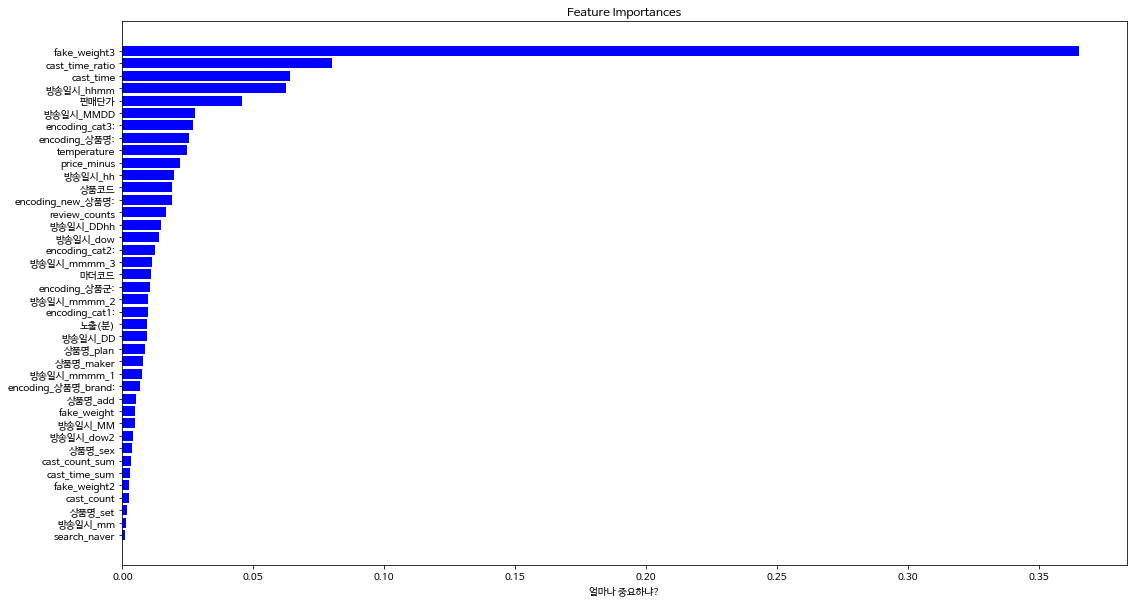

In [ ]:
features = ['노출(분)', '마더코드', '상품코드', '판매단가','cast_time', 'cast_count', 'cast_time_sum', 'cast_count_sum', 'cast_time_ratio','fake_weight',
       '상품명_plan', '상품명_add', '상품명_maker',
       '상품명_set', '상품명_sex', '방송일시_dow', '방송일시_MM', '방송일시_DD', '방송일시_hh',
       '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm', '방송일시_mmmm_1',
       '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2', 'review_counts', 'price_minus', 'search_naver', 'temperature',
       'encoding_상품명:', 'encoding_상품군:', 'encoding_상품명_brand:',
       'encoding_cat1:', 'encoding_cat2:', 'encoding_cat3:','fake_weight2','fake_weight3',
       'encoding_new_상품명:']
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(18,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('얼마나 중요하냐?')
plt.show()

In [ ]:
train_, test_ = train_test_split(train, test_size=0.2, random_state=529)

#train_ = train[train.방송일시_MM != '07']
#test_ = train[train.방송일시_MM == '07']
print(train_.shape)
print(test_.shape)

(28303, 49)
(7076, 49)


In [ ]:
# 인코딩할 컬럼을 리스트로 넣어줍니다.
columns = ['상품명', '상품군', '상품명_brand', 'cat1', 'cat2', 'cat3', 'new_상품명']
number = len(columns)

# 함수로 바로 처리.
label_encoding(train_, test_, columns, number)
train_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28303 entries, 17937 to 6025
Data columns (total 56 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   방송일시                 28303 non-null  object  
 1   노출(분)                28303 non-null  float64 
 2   마더코드                 28303 non-null  int64   
 3   상품코드                 28303 non-null  int64   
 4   상품명                  28303 non-null  object  
 5   상품군                  28303 non-null  object  
 6   판매단가                 28303 non-null  int32   
 7   취급액                  28303 non-null  int32   
 8   cast_time            28303 non-null  float64 
 9   cast_count           28303 non-null  int16   
 10  cast_time_sum        28303 non-null  float64 
 11  cast_count_sum       28303 non-null  float64 
 12  cast_time_ratio      28303 non-null  float64 
 13  상품명_plan             28303 non-null  category
 14  상품명_add              28303 non-null  category
 15  상품명_maker       

In [ ]:
# rating_mean 은 일단 제외하고 학습합니다.
# 변수 순서가 바뀌면 점수가 바뀝니다.

X_train = train_[['노출(분)', '마더코드', '상품코드', '판매단가','cast_time', 'cast_count', 'cast_time_sum', 'cast_count_sum', 'cast_time_ratio','fake_weight',
       '상품명_plan', '상품명_add', '상품명_maker',
       '상품명_set', '상품명_sex', '방송일시_dow', '방송일시_MM', '방송일시_DD', '방송일시_hh',
       '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm', '방송일시_mmmm_1',
       '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2', 'review_counts', 'price_minus', 'search_naver', 'temperature',
       'encoding_상품명:', 'encoding_상품군:', 'encoding_상품명_brand:',
       'encoding_cat1:', 'encoding_cat2:', 'encoding_cat3:','fake_weight2','com',
       'encoding_new_상품명:']].values 
y_train = train_['취급액'].values
X_test = test_[['노출(분)', '마더코드', '상품코드', '판매단가','cast_time', 'cast_count', 'cast_time_sum', 'cast_count_sum','cast_time_ratio','fake_weight',
       '상품명_plan', '상품명_add', '상품명_maker',
       '상품명_set', '상품명_sex', '방송일시_dow', '방송일시_MM', '방송일시_DD', '방송일시_hh',
       '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm', '방송일시_mmmm_1',
       '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2', 'review_counts', 'price_minus', 'search_naver','temperature',
       'encoding_상품명:', 'encoding_상품군:', 'encoding_상품명_brand:',
       'encoding_cat1:', 'encoding_cat2:', 'encoding_cat3:','fake_weight2','com',
      'encoding_new_상품명:']].values 
y_test = test_['취급액'].values

In [ ]:
y_train_log = np.log(y_train)

# np.exp(1)**np.log(10)

In [ ]:
# 로그 표준화한 값을 학습(예측용)
rf = RandomForestRegressor(n_jobs=3, random_state=592)
rf.fit(X_train, y_train_log)
pred_log = rf.predict(X_test)

In [ ]:
def mape(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

pred_log_T = np.exp(1)**pred_log

In [ ]:
mape(y_test, pred_log_T)

34.232734995486375

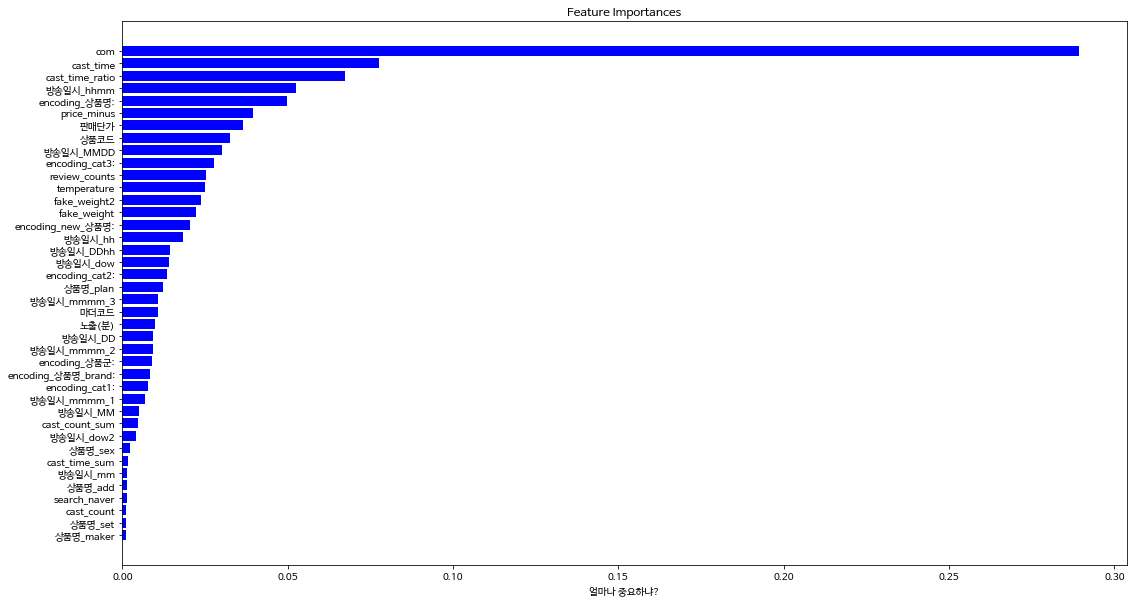

In [ ]:
features = ['노출(분)', '마더코드', '상품코드', '판매단가','cast_time', 'cast_count', 'cast_time_sum', 'cast_count_sum', 'cast_time_ratio','fake_weight',
       '상품명_plan', '상품명_add', '상품명_maker',
       '상품명_set', '상품명_sex', '방송일시_dow', '방송일시_MM', '방송일시_DD', '방송일시_hh',
       '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm', '방송일시_mmmm_1',
       '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2', 'review_counts', 'price_minus', 'search_naver', 'temperature',
       'encoding_상품명:', 'encoding_상품군:', 'encoding_상품명_brand:',
       'encoding_cat1:', 'encoding_cat2:', 'encoding_cat3:','fake_weight2','com',
       'encoding_new_상품명:']
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(18,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('얼마나 중요하냐?')
plt.show()

In [ ]:
search = pd.read_excel('/gdrive/My Drive/datalab.xlsx',skiprows=6)
search.head()

,날짜,NS홈쇼핑 NS,날짜.1,롯데홈쇼핑,날짜.2,GS홈쇼핑,날짜.3,현대홈쇼핑,날짜.4,CJ홈쇼핑
0,2019-01-01,17.30971,2019-01-01,56.97459,2019-01-01,38.37021,2019-01-01,50.46388,2019-01-01,8.50646
1,2019-01-02,17.66025,2019-01-02,60.25098,2019-01-02,37.89114,2019-01-02,46.27374,2019-01-02,7.57869
2,2019-01-03,14.87696,2019-01-03,62.30282,2019-01-03,37.54060,2019-01-03,49.87263,2019-01-03,7.12766
3,2019-01-04,13.96087,2019-01-04,59.56159,2019-01-04,37.43310,2019-01-04,49.71606,2019-01-04,6.97576
4,2019-01-05,14.40957,2019-01-05,65.72410,2019-01-05,50.29562,2019-01-05,63.80313,2019-01-05,8.42466


In [ ]:
search = search[['날짜','NS홈쇼핑 NS']]

In [ ]:
search['날짜'] = search['날짜'].apply(lambda x: x[5:])
search['날짜'] = search['날짜'].apply(lambda x: x.replace('-',''))
search.head()

,날짜,NS홈쇼핑 NS
0,0101,17.30971
1,0102,17.66025
2,0103,14.87696
3,0104,13.96087
4,0105,14.40957


In [ ]:
train = pd.merge(train, search, left_on ='방송일시_MMDD', right_on = '날짜', how = 'left')
train.rename({'NS홈쇼핑 NS':'search_compare'},axis=1, inplace= True)

In [ ]:
train_, test_ = train_test_split(train, test_size=0.2, random_state=529)

#train_ = train[train.방송일시_MM != '07']
#test_ = train[train.방송일시_MM == '07']
print(train_.shape)
print(test_.shape)

(28303, 49)
(7076, 49)


In [ ]:
# 인코딩할 컬럼을 리스트로 넣어줍니다.
columns = ['상품명', '상품군', '상품명_brand', 'cat1', 'cat2', 'cat3', 'new_상품명']
number = len(columns)

# 함수로 바로 처리.
label_encoding(train_, test_, columns, number)
train_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28303 entries, 17937 to 6025
Data columns (total 56 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   방송일시                 28303 non-null  object  
 1   노출(분)                28303 non-null  float64 
 2   마더코드                 28303 non-null  int64   
 3   상품코드                 28303 non-null  int64   
 4   상품명                  28303 non-null  object  
 5   상품군                  28303 non-null  object  
 6   판매단가                 28303 non-null  int32   
 7   취급액                  28303 non-null  int32   
 8   cast_time            28303 non-null  float64 
 9   cast_count           28303 non-null  int16   
 10  cast_time_sum        28303 non-null  float64 
 11  cast_count_sum       28303 non-null  float64 
 12  cast_time_ratio      28303 non-null  float64 
 13  상품명_plan             28303 non-null  category
 14  상품명_add              28303 non-null  category
 15  상품명_maker       

In [ ]:
# rating_mean 은 일단 제외하고 학습합니다.
# 변수 순서가 바뀌면 점수가 바뀝니다.

X_train = train_[['노출(분)', '마더코드', '상품코드', '판매단가','cast_time', 'cast_count', 'cast_time_sum', 'cast_count_sum', 'cast_time_ratio','fake_weight',
       '상품명_plan', '상품명_add', '상품명_maker',
       '상품명_set', '상품명_sex', '방송일시_dow', '방송일시_MM', '방송일시_DD', '방송일시_hh',
       '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm', '방송일시_mmmm_1',
       '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2', 'review_counts', 'price_minus', 'search_naver', 'temperature',
       'encoding_상품명:', 'encoding_상품군:', 'encoding_상품명_brand:',
       'encoding_cat1:', 'encoding_cat2:', 'encoding_cat3:','fake_weight2','search_compare',
       'encoding_new_상품명:']].values 
y_train = train_['취급액'].values
X_test = test_[['노출(분)', '마더코드', '상품코드', '판매단가','cast_time', 'cast_count', 'cast_time_sum', 'cast_count_sum','cast_time_ratio','fake_weight',
       '상품명_plan', '상품명_add', '상품명_maker',
       '상품명_set', '상품명_sex', '방송일시_dow', '방송일시_MM', '방송일시_DD', '방송일시_hh',
       '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm', '방송일시_mmmm_1',
       '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2', 'review_counts', 'price_minus', 'search_naver','temperature',
       'encoding_상품명:', 'encoding_상품군:', 'encoding_상품명_brand:',
       'encoding_cat1:', 'encoding_cat2:', 'encoding_cat3:','fake_weight2','search_compare',
      'encoding_new_상품명:']].values 
y_test = test_['취급액'].values

In [ ]:
y_train_log = np.log(y_train)

# np.exp(1)**np.log(10)

In [ ]:
# 로그 표준화한 값을 학습(예측용)
rf = RandomForestRegressor(n_jobs=3, random_state=592)
rf.fit(X_train, y_train_log)
pred_log = rf.predict(X_test)

In [ ]:
mape(y_test, pred_log_T)

34.232734995486375

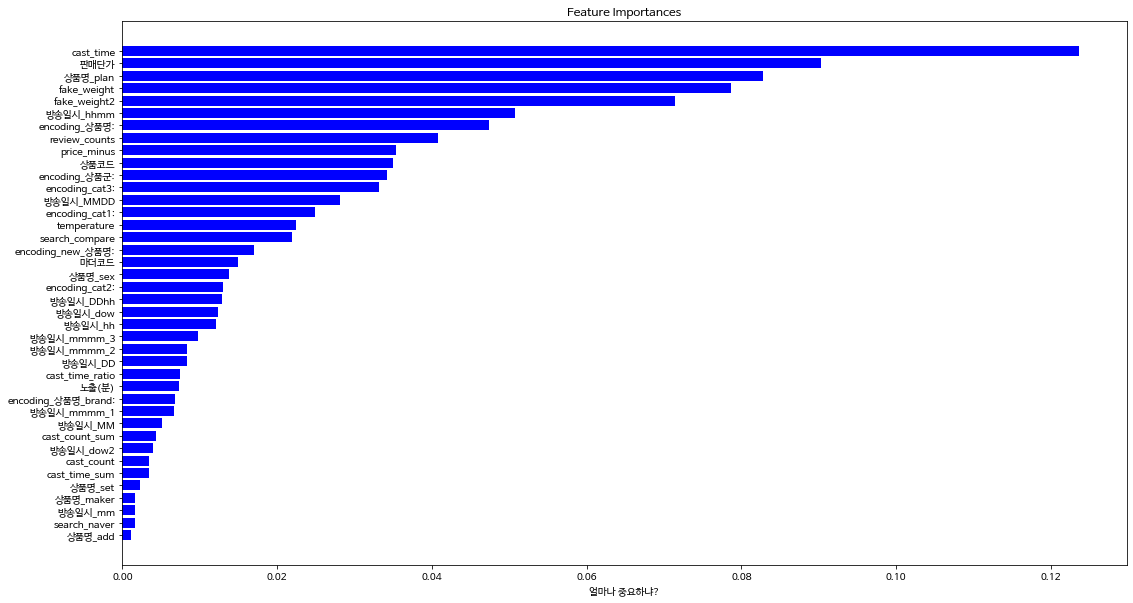

In [ ]:
features = ['노출(분)', '마더코드', '상품코드', '판매단가','cast_time', 'cast_count', 'cast_time_sum', 'cast_count_sum', 'cast_time_ratio','fake_weight',
       '상품명_plan', '상품명_add', '상품명_maker',
       '상품명_set', '상품명_sex', '방송일시_dow', '방송일시_MM', '방송일시_DD', '방송일시_hh',
       '방송일시_mm', '방송일시_MMDD', '방송일시_DDhh', '방송일시_hhmm', '방송일시_mmmm_1',
       '방송일시_mmmm_2', '방송일시_mmmm_3', '방송일시_dow2', 'review_counts', 'price_minus', 'search_naver', 'temperature',
       'encoding_상품명:', 'encoding_상품군:', 'encoding_상품명_brand:',
       'encoding_cat1:', 'encoding_cat2:', 'encoding_cat3:','fake_weight2','search_compare',
       'encoding_new_상품명:']
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(18,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('얼마나 중요하냐?')
plt.show()